In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("imported")
import random
import os
import sys
import itertools
sys.path.append('src/')
import nn
import process_data
import nibabel as nib
from math import floor, ceil
# import cv2

from __future__ import division, print_function, absolute_import
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure
from skimage.io import imread, imsave
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print(local_device_protos)

imported
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11934193545933816460
]


# Data Methods

In [2]:
def one_hot_encode(L, class_labels):
    """
    2D array (image) of segmentation labels -> .npy
    # One Hot Encode the label 2d array -> .npy files with dim (h, w, len(class_labels))
    # num classes will be 8? but currently dynamically allocated based on num colors in all scans.
    """
    h, w = L.shape  # Should be 482, 395 (unless resized)
    try:
        encoded = np.array([list(map(class_labels.index, L.flatten()))])

        L = encoded.reshape(h, w)

        Lhot = np.zeros((L.shape[0], L.shape[1], len(class_labels)))
        for i in range(L.shape[0]):
            for j in range(L.shape[1]):
                Lhot[i,j,L[i,j]] = 1
        return Lhot  # Should be shape (482, 395, 9)
    except Exception as e:
        print(e)

def uncode_one_hot(npy_file):
    """
    .npy file -> JPEG
    """
    pass

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
def load_sparse_csr(filename):
    # Sparse matrix reading function to read our raw .npz files
    assert filename.endswith('.npz')
    loader = np.load(filename)  # filename must end with .npz
    return scipy.sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

def get_raw_pixel_classes(trial_name, raw_nifti_dir):
    trial_segmentation = None
    
    for raw_nii in os.listdir(raw_nii_dir):
        if raw_nii.startswith(trial_name) and raw_nii.endswith(".nii"):
            if "seg" in raw_nii:
                trial_segmentation = os.path.join(raw_nii_dir, raw_nii)
                break
    
    scan_voxel = nib.load(trial_segmentation)
    struct_arr = scan_voxel.get_data()
    class_labels = sorted(list(np.unique(struct_arr)))
    return class_labels
    
def check_one_hot(encoded_img):
    print(encoded_img.shape)
    return np.all(np.sum(encoded_img, axis=2) == 1.)

def batch_img_resize(images, h = 256, w = 256):
    images_resized = np.zeros([0, newHeight, newWidth], dtype=np.uint8)
    for image in range(images.shape[0]):
        temp = imresize(images[image], [h, w], 'nearest')
        images_resized = np.append(images_resized, np.expand_dims(temp, axis=0), axis=0)
    return images_resized

def crop_cross_sec(cross_sec, height, width):
    orig_height, orig_width = cross_sec.shape
    height_remove = (orig_height - height) / 2
    width_remove = (orig_width - width) / 2
    ht_idx_1 = floor(height_remove)
    ht_idx_2 = ceil(height_remove)
    wd_idx_1 = floor(width_remove)
    wd_idx_2 = ceil(width_remove)
    
    cropped = cross_sec[ht_idx_1:orig_height-ht_idx_2, wd_idx_1:orig_width-wd_idx_2]
    
    return cropped

def pad_image(orig_img, height, width):    
    orig_height, orig_width = orig_img.shape
    
    height_pad = (height - orig_height) / 2
    width_pad = (width - orig_width) / 2
    
    height_top_pad = floor(height_pad)
    height_bot_pad =  ceil(height_pad)
    width_left_pad = floor(width_pad)
    width_right_pad = ceil(width_pad)
    
    pad_dims = ((height_top_pad, height_bot_pad), (width_left_pad, width_right_pad))
    padded_img = np.pad(orig_img, pad_width=pad_dims, mode='constant', constant_values=0)
    
    return padded_img

def pad_processed_data():
    pass
    

def load_all_data(processed_data_dir=None, height=512, width=512):
    """
    Load both the processed, unlabeled data as well as corresponding labeled segmentation data (if it
    exists) of all scans in a directory. Can draw from an arbitrary number of scan/segmentation pairs. 
    All raw data ends up in the same array, all segmentation data ends up in the same array.
    
    Args:
        processed_data_dir (str): Path to directory containing separate folders for the preprocessed
            data, where each folder contains all .npz and .png files for one scan. Sub-folder names
            expected to resemble e.g. "trial8_30_fs".
        height (int): Height in pixels to which scan cross sections get resized.
        width (int): Width in pixels to which scan cross sections get resized.
            
    Returns:
        tuple: Tuple of lists of numpy arrays where the first list contains the raw data, is of length 
            N (total number of cross sections from all scans), and each element is a numpy array of shape
            (height, width). The second list contains the segmented data and is of length N and
            contains numpy arrays of shape (height, width, C) where C is the number of
            pixel classes. By default C is 9. Class dimension is one-hot-encoded.
    """
    raw_images = []
    segmentations = []    
    scan_paths = []
    
    for folder in os.listdir(processed_data_dir):
        if not folder.startswith('.') and 'trial' in folder.lower():
            scan_folder_path = os.path.join(processed_data_dir, folder)
            scan_paths.append(scan_folder_path)
    
    print(scan_paths)
    
    for scan_path in scan_paths:
        scan_data_raw, scan_data_labels = load_data(scan_path, height, width)
        raw_images.extend(scan_data_raw)
        segmentations.extend(scan_data_labels)
    
    return raw_images, segmentations

def load_data(processed_data_dir=None, height=512, width=512):
    """
    Load both the processed, unlabeled data as well as corresponding labeled segmentation data (if it
    exists) of a single scan. 
    
    Args:
        processed_data_dir (str): Path to directory containing the .npz and .png files for a single scan.
            Name of this directory does not matter. Directory should only contain the relevant processed
            scan data, not any other files.
        height (int): Height in pixels to which scan cross sections get resized.
        width (int): Width in pixels to which scan cross sections get resized.
    
    Returns:
        tuple: Tuple of lists of numpy arrays where the first list contains the raw data, is of length 
            N (total number of cross sections from the scan), and each element is a numpy array of shape
            (height, width). The second list contains the segmented data and is of length N and
            contains numpy arrays of shape (height, width, C) where C is the number of
            pixel classes. By default C is 9. Class dimension is one-hot-encoded.
    
    """
    default_raw_pixel_classes = [0, 7, 8, 9, 45, 51, 52, 53, 68]
    raw_images = []
    segmentations = []    
    scan_files = []
    
    print("====")
    print(processed_data_dir)
    print("====")
    
    for item in os.listdir(processed_data_dir):
        item_path = os.path.join(processed_data_dir, item)
        if os.path.isfile(item_path) and not item.startswith('.'):
            scan_files.append(item)
        
    scan_files = sorted(scan_files)
    
    for file in scan_files:
        print(file, end=' ')
        if 'label' in file:
            img = imread(os.path.join(processed_data_dir, file), flatten=True)
        else:
            img = load_sparse_csr(os.path.join(processed_data_dir, file)).toarray() 
        
        img = pad_image(img, height, width)
        if 'raw' in file:
            raw_images.append(img)
        elif 'label' in file:
            encoded_img = one_hot_encode(img, default_raw_pixel_classes)
            segmentations.append(encoded_img)
    
    return raw_images, segmentations
            

def save_seg_as_nifti(seg, target_dir, nii_data_dir):
    '''
    TODO: Fix to be compatible with predict_all_segs function, arbitrary scans.
    '''
    original_vol = nib.load(os.path.join(nii_data_dir, 'trial15_60_w1_volume_TRANS.nii'))
    new_header = original_vol.header.copy()
    new_nifti = nib.nifti1.Nifti1Image(seg, None, header=new_header)
    nib.save(new_nifti, '/home/jessica/Documents/hart-seg-ml/predictedsegs/trial15_60_w1_first/trial15_60_w1_first_pred_seg.nii')


# Prediction Methods

In [9]:
def predict_cross_sec(x, model, sess):
    prediction = model.predict(sess, x)
    pred_classes = np.argmax(prediction[0], axis=2)
    return pred_classes

def predict_whole_seg(X, model, sess):
    '''
    Todo: Crop the predictions. 
    '''
    segmented = np.empty(X.shape[:3])
    num_sections = X.shape[0]
    for i in range(num_sections):
        pred = predict_cross_sec(X[i:i+1], model, sess)
        segmented[i] = pred
        print(i, end=', ')
    return segmented

def predict_all_segs(to_segment_dir, save_dir, nii_data_dir, model, sess):
    """
    Produce segmentations of arbitrary number of preprocessed scans and save them all as Nifti
    files. Each preprocessed scan should be in separate subfolder. Names of folders containing 
    scan data should start with "trial".
    """
    scan_paths = []
    
    for folder in os.listdir(to_segment_dir):
        print(folder, end=' ')
        if folder.startswith('trial'):
            scan_path = os.path.join(to_segment_dir, folder)
            scan_paths.append(scan_path)
            
    print("")
    
    for scan_path in scan_paths:
        raw_scan_data, ignore = load_data(scan_path)
        print(scan_path, ":", len(raw_scan_data), end=' ')
        # segmented_scan = predict_whole_seg(raw_scan_data, model, sess)
        # save_seg_as_nifti(segmented_scan, save_dir, nii_data_dir)
        
        

# Other Methods

In [4]:
def save_model(models_dir, model_name):
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(os.path.join(models_dir, model_name), model_name))

# Read Data

In [5]:
nii_data_dir = "/Users/nozik/Documents/HARTresearch/allrawnifti"
pipeline_test_dir = "/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test"
ORIGINAL_DIMS = (482, 395)

In [6]:
raw_data, seg_data = load_all_data(pipeline_test_dir)

['/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/trial12_30_w3', '/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/trial15_60_w1']
====
/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/trial12_30_w3
====
0_label.png 0_raw.npz 10_label.png 10_raw.npz 11_label.png 11_raw.npz 12_label.png 12_raw.npz 13_label.png 13_raw.npz 14_label.png 14_raw.npz 15_label.png 15_raw.npz 16_label.png 16_raw.npz 17_label.png 17_raw.npz 18_label.png 18_raw.npz 19_label.png 19_raw.npz 1_label.png 1_raw.npz 20_label.png 20_raw.npz 21_label.png 21_raw.npz 22_label.png 22_raw.npz 23_label.png 23_raw.npz 24_label.png 24_raw.npz 25_label.png 25_raw.npz 26_label.png 26_raw.npz 27_label.png 27_raw.npz 28_label.png 28_raw.npz 29_label.png 29_raw.npz 2_label.png 2_raw.npz 30_label.png 30_raw.npz 3_label.png 3_raw.npz 4_label.png 4_raw.npz 5_label.png 5_raw.npz 6_label.png 6_raw.npz 7_label.png 7_raw.npz 8_label.png 8_raw.npz 9_label.png 9_raw.npz ====
/Users/nozi

In [7]:
print(len(raw_data))
print(len(seg_data))

raw_data_arr = np.array(raw_data)
seg_data_arr = np.array(seg_data)

print(raw_data_arr.shape)
print(seg_data_arr.shape)


62
62
(62, 512, 512)
(62, 512, 512, 9)


(512, 512)
(482, 395)


[]

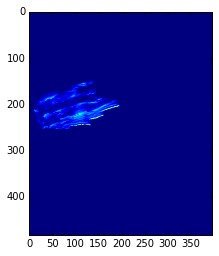

In [8]:
example_img = raw_data_arr[0]
print(example_img.shape)
cropped_example = crop_cross_sec(example_img, 482, 395)
print(cropped_example.shape)

#plt.imshow(example_img)
plt.imshow(cropped_example)
plt.plot()


In [10]:
train_data_dir = "/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/test_prediction_methods/train_on_these"
scans_to_segment_dir = "/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/test_prediction_methods/predict_these"
seg_results_dir = "/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/test_prediction_methods/train_on_these/put_results_here"

predict_all_segs(pipeline_test_dir, seg_results_dir, None, None, None)


.DS_Store test_prediction_methods trial12_30_w3 trial15_60_w1 
====
/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/trial12_30_w3
====
0_label.png 0_raw.npz 10_label.png 10_raw.npz 11_label.png 11_raw.npz 12_label.png 12_raw.npz 13_label.png 13_raw.npz 14_label.png 14_raw.npz 15_label.png 15_raw.npz 16_label.png 16_raw.npz 17_label.png 17_raw.npz 18_label.png 18_raw.npz 19_label.png 19_raw.npz 1_label.png 1_raw.npz 20_label.png 20_raw.npz 21_label.png 21_raw.npz 22_label.png 22_raw.npz 23_label.png 23_raw.npz 24_label.png 24_raw.npz 25_label.png 25_raw.npz 26_label.png 26_raw.npz 27_label.png 27_raw.npz 28_label.png 28_raw.npz 29_label.png 29_raw.npz 2_label.png 2_raw.npz 30_label.png 30_raw.npz 3_label.png 3_raw.npz 4_label.png 4_raw.npz 5_label.png 5_raw.npz 6_label.png 6_raw.npz 7_label.png 7_raw.npz 8_label.png 8_raw.npz 9_label.png 9_raw.npz /Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/trial12_30_w3 : 31 ====
/Users/nozik/Documents/HARTrese

TODO: rename loading functions to something like load trials; check that get raw pixel classes still works